# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
# imports
import numpy as np;

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

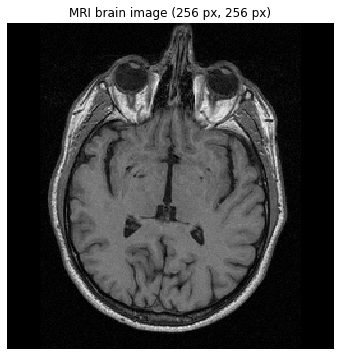

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

In [53]:
import cv2
import numpy as np

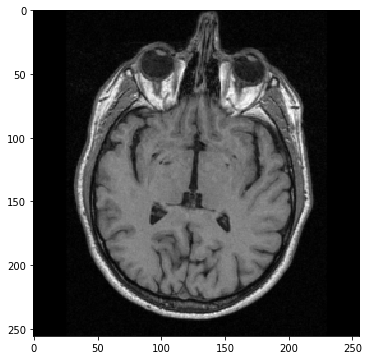

In [54]:
# Using Gaussian filter to denoise image
brain_denoise = cv2.GaussianBlur(brain_im,(5,5),0.5,0.5)
plt.figure(figsize=[6,6])
plt.imshow(brain_denoise,cmap='gray')

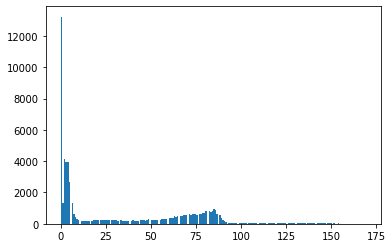

In [55]:
plt.hist(brain_denoise.ravel(),bins=200)
plt.show()

In [56]:
def region_growing(img, seed, threshold):

    img = np.float32(img)
    
    # 8-connected growing method
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),(-1,-1),(-1,1),(1,1),(1,-1)]
    region_size = 1
    neighbor_points_list = []
    neighbor_points_list.append(seed)
    
    #Initialize segmented output image
    height,width = img.shape
    segmented_img = np.zeros((height, width), np.uint8)
    
    while len(neighbor_points_list) != 0:  
        
        seed = neighbor_points_list.pop(0)
        for i in range(8):
            
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]
            
            checkout = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)
            if checkout:
                if segmented_img[x_new, y_new] == 0:
                    
                    # compute difference
                    difference = np.abs(img[x_new,y_new]-img[seed[0],seed[1]])
                    
                    if difference <= threshold:
                        
                        neighbor_points_list.append([x_new,y_new])
                        segmented_img[x_new, y_new] = 255
                        region_size+=1
                        
    return segmented_img,region_size

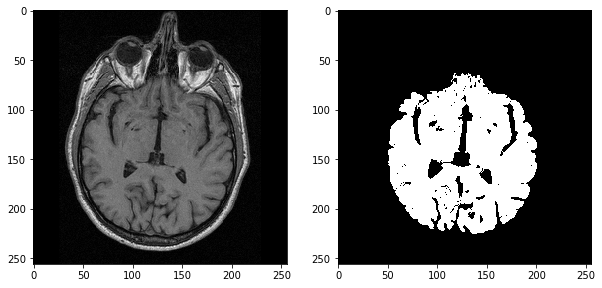

In [57]:
# set seed
seed = [153,82]
segmented_img, region_size = region_growing(brain_denoise, seed, 4)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(segmented_img,cmap='gray')
plt.show()

In [13]:
print("The brain size is ",region_size)

The brain size is  15049


In [ ]:
# try to combine the two thresholding parameters to get better result

##### 1.3 Contour detection
Add your implementation and discussion

### Canny edge detection (multi-stage algorithm)

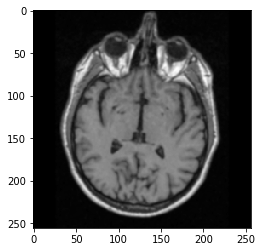

In [13]:
from scipy import ndimage

# # riscrivere la funzione!!
# def gaussian_kernel(size, sigma=1):
#     size = int(size) // 2
#     x, y = np.mgrid[-size:size+1, -size:size+1]
#     normal = 1 / (2.0 * np.pi * sigma**2)
#     g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
#     return g

# image_denoised = ndimage.convolve(brain_im, gaussian_kernel(5), mode='constant', cval=0.0)
# plt.imshow(image_denoised, cmap='gray')
# plt.show()

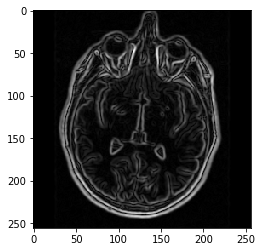

In [15]:
# # show gradients code
# import scipy
# from scipy import ndimage

# image_denoised = image_denoised.astype('int32')
# dx = ndimage.sobel(image_denoised, 0)  # horizontal derivative
# dy = ndimage.sobel(image_denoised, 1)  # vertical derivative
# image_gradients = np.hypot(dx, dy)  # magnitude
# image_gradients *= 255.0 / np.max(image_gradients)  # normalize (Q&D)
# plt.imshow(image_gradients, cmap='gray')
# plt.show()

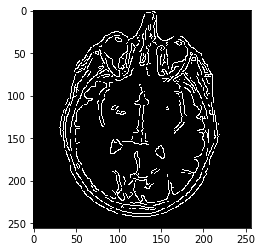

In [73]:
# Canny algorithm
# 1) Noise reduction
# 2) Gradient calculation
# 3) Non-maximum suppression
# 4) Double threshold
# 5) Edge Tracking by Hysteresis

from skimage import feature

edges = skimage.feature.canny(
    image=brain_im,
    sigma=0.9,
    low_threshold=55,
    high_threshold=90,
)

# display edges
plt.imshow(edges, cmap='gray')
plt.show()

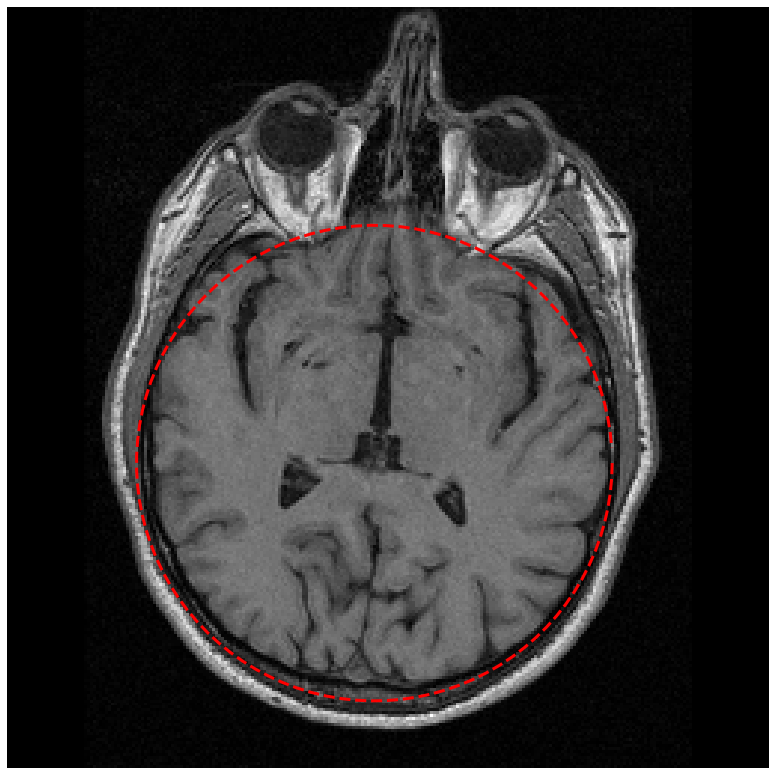

In [109]:
# Active Contour segmentation (snakes)
# riscrivere!

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(100, [153, 123], 80)[:-1]
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)


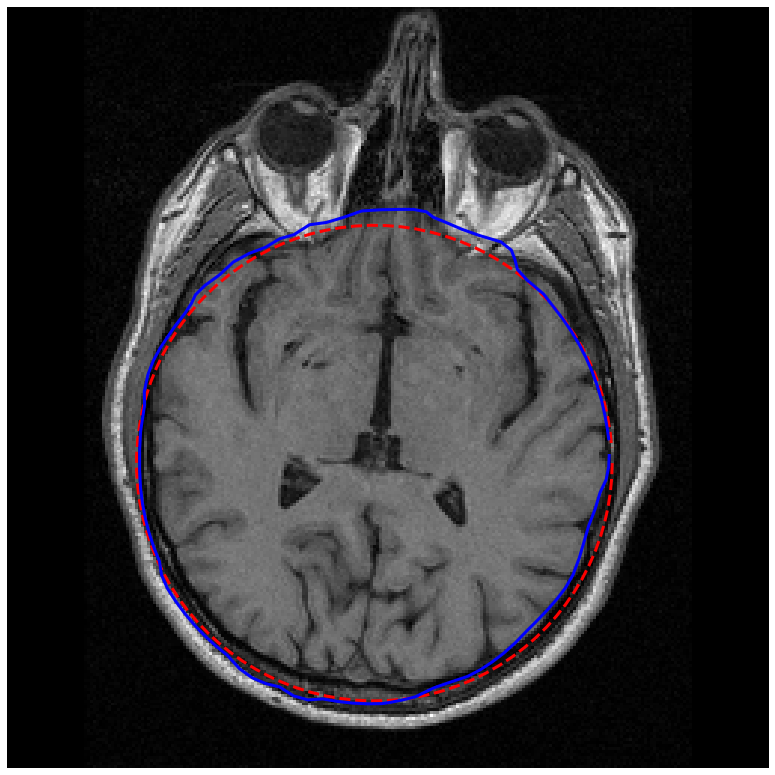

In [129]:
snake = skimage.segmentation.active_contour(brain_im, points, alpha=0.002, beta=1, gamma=0.001)
fig, ax = image_show(brain_im)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

# todo detect params alpha, beta, gamma

### 1.4 Additional method(s)
Add your implementation and discussion

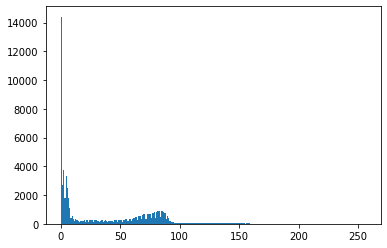

In [4]:
# Histogram
plt.hist(brain_im.ravel(), 256,[0,256])
plt.show()

# Threshold
def threshold(t1, t2, img):
    th_img = img.copy()
    th_img[th_img < t1] = 0
    th_img[th_img > t2] = 0
    th_img[(th_img >= t1) & (th_img <= t2)] = 1
    return th_img

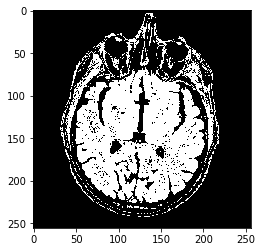

In [5]:
# apply threshold
th_img_wdg = threshold(55, 90, brain_im)
plt.imshow(th_img_wdg, cmap='gray')
plt.show()

# Adaptive thresholding does not make sense since we will have the same intensities in all the image (e.g. no more exposition in a part of the image)

array([71.30357143, 83.375     ])

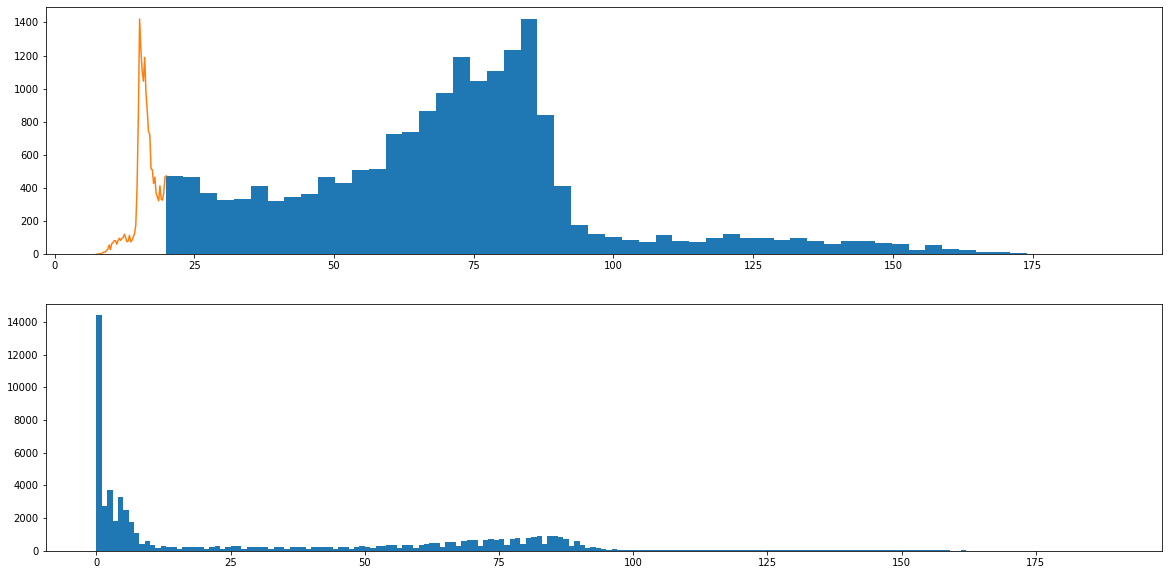

In [30]:
# Gaussian fitting histogram
import scipy
from scipy import ndimage
import numpy as np
gd = ndimage.gaussian_filter(brain_im, sigma=.1)
gx = ndimage.sobel(brain_im,axis=0,mode='constant')
gyx = ndimage.sobel(gx,axis=1,mode='constant')
data = brain_im.copy()
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
#for better peak-valley ratio, kept only big gradient pixels
hsmooth = 3 #combine histogram bins to smooth histogram
Nb = int(round((max(data[gyx>100])-20)/hsmooth)) # number of bins
h = ax[0].hist(data[gyx>100].ravel(),bins = Nb, range = (20,max(data[gyx>100])));
ax[1].hist(data.ravel(),bins = max(data.ravel()));


ax[0].plot(np.linspace(start=20, stop=7.5, num=Nb),h[0])
peaks, _ = scipy.signal.find_peaks(h[0], height=1000)
h[1][peaks]

In [28]:
bins

NameError: name 'bins' is not defined

In [21]:
a = int(3.5)
a

3

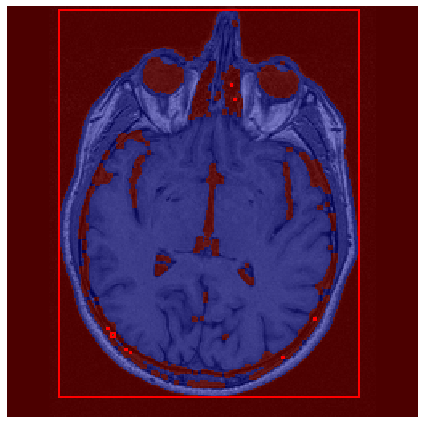

42

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [9]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


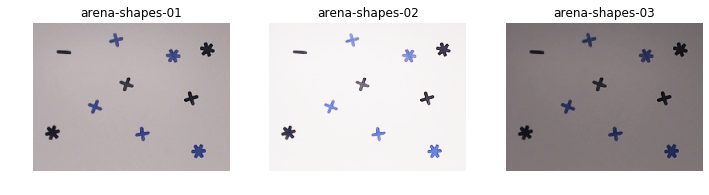

In [10]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion